This is notebook that tries out diffrent method used for **anomaly detection**

In [1]:
## imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline


In [32]:
# Generate anomaly data
per_anomlay = 0.1
n_dim = 5
n_normal = 1000
n_anomlay = int(per_anomlay * n_normal)
normal_data = np.random.multivariate_normal(mean= 10 * np.ones(n_dim), cov=np.eye(5), size=(n_normal,))
anomaly_data = np.random.multivariate_normal(mean= 4 * np.ones(n_dim), cov=np.eye(5), size=(n_anomlay,))
X = np.concatenate((normal_data, anomaly_data), axis=0)
Label = np.zeros(X.shape[0])
Label[-n_anomlay:] = 1
print(X.shape)
np.where(Label == 1)[0].shape

(1100, 5)


(100,)

In [4]:
!pip install umap_learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[[ 8.642799    4.9101925 ]
 [-4.272063   -0.14034033]]


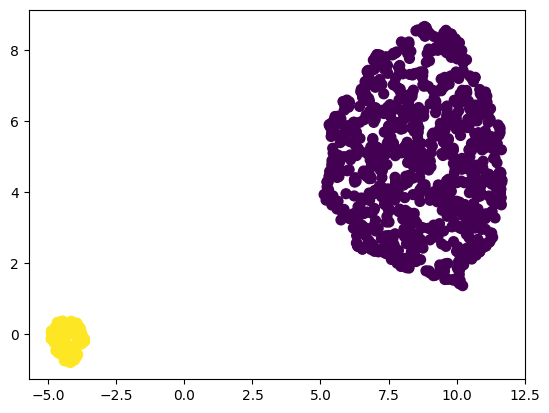

In [6]:
# Dimensionality reduction Methods
# PCA, tSNE, UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans

# PCA
# norm_X = StandardScaler().fit_transform(X)
# traformed_data_pca = PCA(n_components=2).fit_transform(norm_X)
# plt.scatter(traformed_data_pca[:, 0], traformed_data_pca[:, 1], s=50, c=Label)

# tSNE
# norm_X = StandardScaler().fit_transform(X)
# traformed_data_pca = TSNE(n_components=2).fit_transform(norm_X)
# plt.scatter(traformed_data_pca[:, 0], traformed_data_pca[:, 1], s=50, c=Label)

# UMAP
norm_X = StandardScaler().fit_transform(X)
umap_dr = umap.UMAP(n_components=2, random_state=42)
traformed_data_pca = umap_dr.fit_transform(norm_X)
# plt.scatter(traformed_data_pca[:, 0], traformed_data_pca[:, 1], s=50, c=Label)
# Kmeans

newdata = traformed_data_pca[:, :2]
kmeans = KMeans(n_clusters=2) # Note that K-means may not work good
 # since it works based on mean of the data and/or dataset is heavily unbalanced
kmeans.fit(newdata)
print(kmeans.cluster_centers_)
plt.scatter(newdata[:, 0], newdata[:, 1], s=50, c=kmeans.labels_)

Text(0.5, 1.0, 'The elbow is clear!')

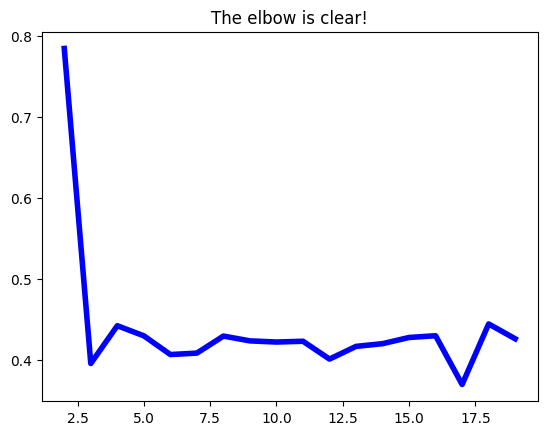

In [8]:
# Let's try out diffrent number of clusters
from sklearn.metrics import silhouette_score
numclusters = np.arange(2, 20, 1)
scores = []
newdata = traformed_data_pca[:, :2]
for ci in numclusters:
  kmeans = KMeans(n_clusters=ci)
  kmeans.fit(newdata)
  scores.append(silhouette_score(X=newdata, labels=kmeans.labels_))

plt.plot(numclusters, scores, lw=4, c='b')
plt.title('The elbow is clear!')


# print(kmeans.cluster_centers_)
# plt.scatter(newdata[:, 0], newdata[:, 1], s=50, c=kmeans.labels_)

(0,)


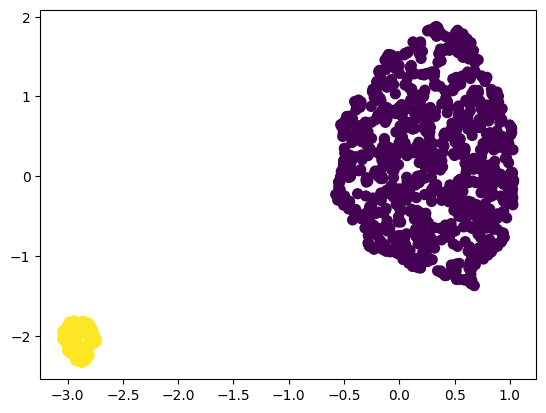

In [10]:
# Let's try other clustring methods, GMM and DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

newdata = StandardScaler().fit_transform(newdata)
gmm = GaussianMixture(n_components=2)
fitted = gmm.fit(newdata)
labels = fitted.fit_predict(newdata)
# plt.scatter(newdata[:, 0], newdata[:, 1], s=50, c=labels)

db_clustring = DBSCAN(eps=0.5, min_samples=5) # this is generally good for unlabanced data
db_clustring.fit(newdata)
labels = db_clustring.fit_predict(newdata)
plt.scatter(newdata[:, 0], newdata[:, 1], s=50, c=labels)
print(labels[labels == -1].shape)

(array([ 1.,  4.,  3.,  2.,  2.,  1.,  6.,  4., 10.,  9.,  9.,  6., 16.,
         8., 24., 19., 21., 14., 21., 17., 22., 17., 29., 18., 29., 30.,
        26., 31., 24., 31., 43., 25., 25., 35., 25., 28., 26., 34.,  9.,
        30., 19., 30., 17., 23., 19., 16., 14.,  7., 22.,  9., 12., 11.,
        14.,  5., 11.,  8.,  8.,  5.,  5., 10.,  8., 11.,  9.,  6.,  8.,
         3.,  3.,  5.,  4.,  3.,  6.,  6.,  5.,  3.,  1.,  0.,  4.,  1.,
         1.,  1.,  3.,  1.,  0.,  0.,  2.,  2.,  1.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.18151155, 0.20606989, 0.23062824, 0.25518658, 0.27974493,
        0.30430328, 0.32886162, 0.35341997, 0.37797831, 0.40253666,
        0.427095  , 0.45165335, 0.47621169, 0.50077004, 0.52532838,
        0.54988673, 0.57444508, 0.59900342, 0.62356177, 0.64812011,
        0.67267846, 0.6972368 , 0.72179515, 0.74635349, 0.77091184,
        0.79547018, 0.82002853, 0.84458688, 0.86914522, 0.89370357,
        0.91826191, 0.9428

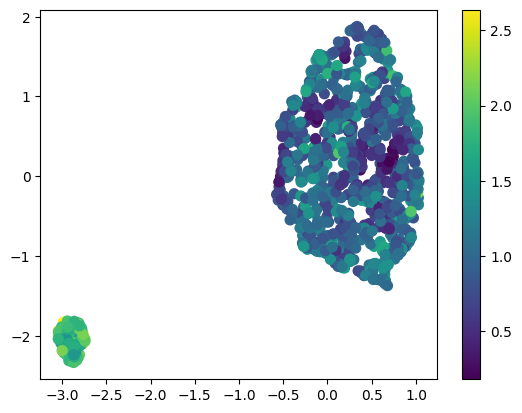

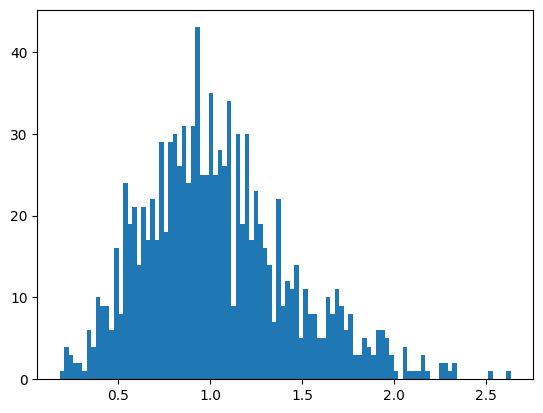

In [13]:

# Mahabolis distance

from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler

dis_mat = []
X_norm = StandardScaler().fit_transform(X)
for x in X_norm:
  dis_mat.append(mahalanobis(x, np.mean(X_norm, axis=0), np.linalg.inv(np.cov(X.T))))

plt.scatter(newdata[:, 0], newdata[:, 1], s=50, c=np.array(dis_mat))
plt.colorbar()
plt.figure()
plt.hist(dis_mat, 100)


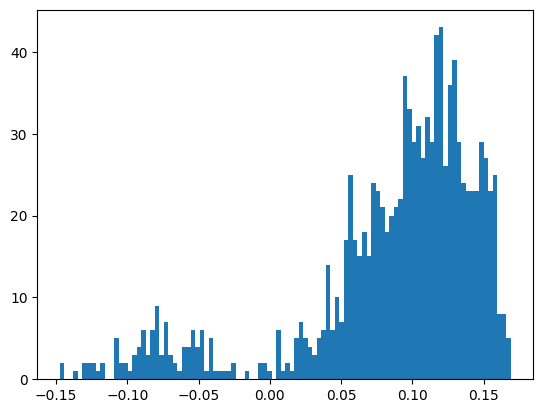

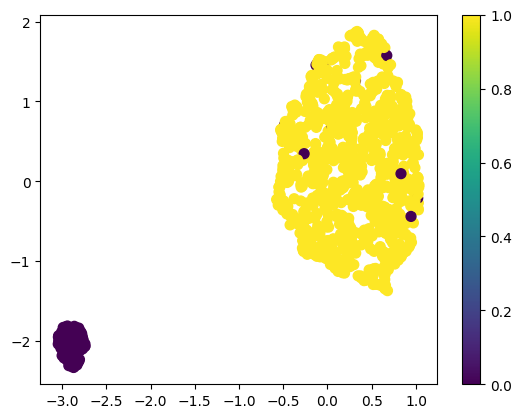

In [14]:
# Isolated Forrest
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

X_norm = StandardScaler().fit_transform(X)

i_forrest = IsolationForest(contamination = 0.1) # contamination: portion of the data we think it might be outlier beforhand
i_forrest.fit(X_norm)
labels = i_forrest.predict(X_norm)
scores = i_forrest.decision_function(X_norm)

plt.hist(scores, 100)
labels = np.ones(labels.shape)
labels[scores < -0.0] = 0
plt.figure()
plt.scatter(newdata[:, 0], newdata[:, 1], s=50, c=labels)
plt.colorbar()

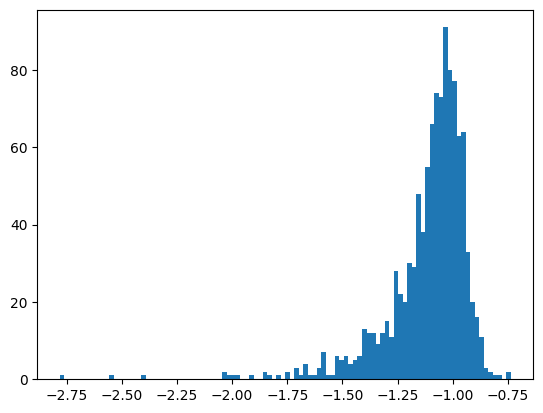

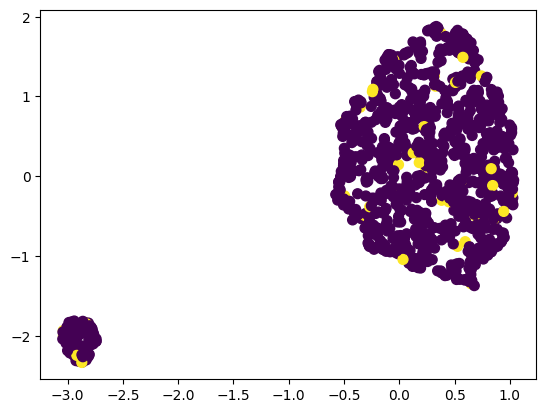

In [19]:
# LOF, this is local method, but sometimes very effective
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

X_norm = StandardScaler().fit_transform(X)

lof = LocalOutlierFactor(n_neighbors=10, contamination = 0.1)
lof.fit(X_norm)
label = lof.fit_predict(X_norm)
scores = lof.negative_outlier_factor_
plt.hist(scores, 100)
plt.figure()
label[scores < -1.5] = 1
label[scores > -1.5] = 0

plt.scatter(newdata[:, 0], newdata[:, 1], s=50, c=label)

(110,)


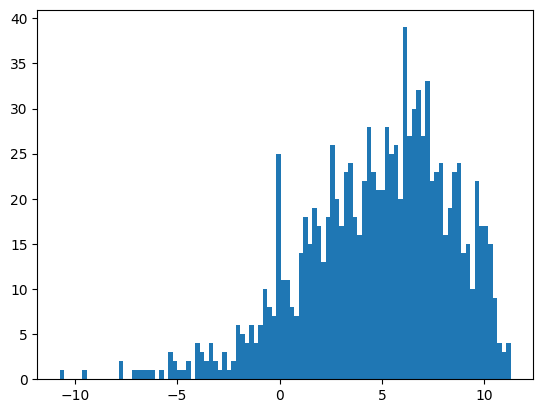

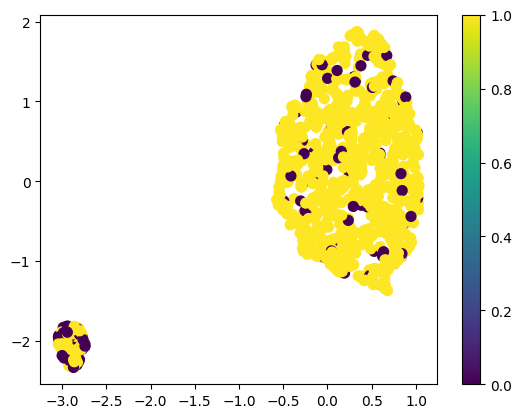

In [26]:
# One class SVM
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

X_norm = StandardScaler().fit_transform(X)

svm = OneClassSVM(nu=0.1, gamma = 1/X_norm.shape[1])  # gamma= shape of the boundary and nu is similar to the contamination para in other methods
svm.fit(X_norm)
label = svm.fit_predict(X_norm)
scores = svm.decision_function(X_norm)
plt.hist(scores, 100)
# print(np.where(scores < 0)[0].shape)
plt.figure()
label[scores < 0] = 0
label[scores >= 0] = 1
plt.scatter(newdata[:, 0], newdata[:, 1], s=50, c=label)
plt.colorbar()
print(np.where(label == 0)[0].shape)

Control for **unbalanced datasets**


(1100, 5)


(array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         500.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

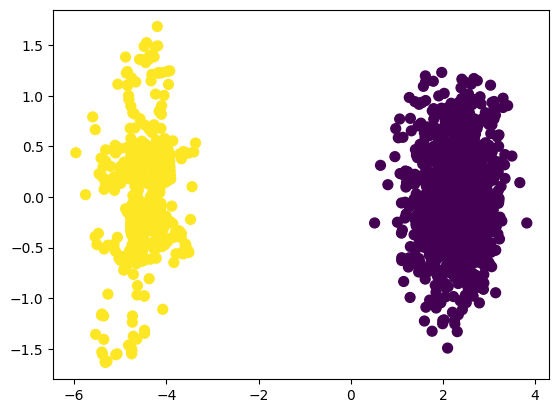

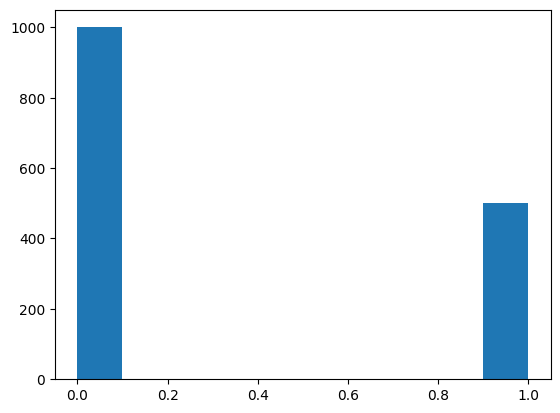

In [28]:
# SMOTE Method
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_norm = StandardScaler().fit_transform(X)

up_sampling = SMOTE(sampling_strategy = 0.5)
print(X_norm.shape)
# data = np.concatenate((X_norm, np.expand_dims(Label, axis=1)), axis=1)
X_train, X_label = up_sampling.fit_resample(X_norm, Label)

pca = PCA(n_components=2)
tr_data = pca.fit_transform(X_train)
plt.figure,
plt.scatter(tr_data[:, 0], tr_data[:, 1], s=50, c=X_label)
plt.figure()
plt.hist(X_label)

(1100, 5)


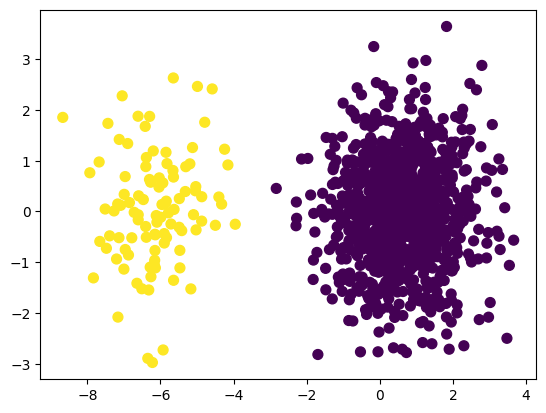

In [29]:
# Generate new data for classfiaiton
from sklearn.decomposition import PCA

per_anomlay = 0.1
n_dim = 5
n_normal = 1000
n_anomlay = int(per_anomlay * n_normal)
normal_data = np.random.multivariate_normal(mean= 5 * np.ones(n_dim), cov=np.eye(5), size=(n_normal,))
anomaly_data = np.random.multivariate_normal(mean= 2 * np.ones(n_dim), cov=np.eye(5), size=(n_anomlay,))
X = np.concatenate((normal_data, anomaly_data), axis=0)
Label = np.zeros(X.shape[0])
Label[-n_anomlay:] = 1
print(X.shape)
np.where(Label == 1)[0].shape

pca = PCA(2).fit_transform(X)
plt.scatter(pca[:, 0], pca[:, 1], s=50, c=Label)


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       195
         1.0       1.00      0.96      0.98        25

    accuracy                           1.00       220
   macro avg       1.00      0.98      0.99       220
weighted avg       1.00      1.00      1.00       220



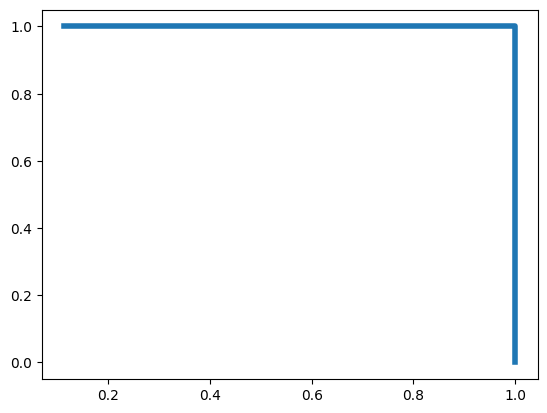

In [30]:
# suppervised methods
# Gradient boosting, random forrest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_auc_score, precision_recall_curve, precision_recall_fscore_support, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Label, test_size=0.2)
# print(train_y.shape)


train_x = StandardScaler().fit_transform(train_x)
test_x = StandardScaler().fit_transform(test_x)


r_forrest = RandomForestClassifier()
r_forrest.fit(train_x, train_y)
pred = r_forrest.predict(test_x)
pred_prop = r_forrest.predict_proba(test_x)[:, 1]
pred_prop.shape
percision, recall, _ = precision_recall_curve(test_y, pred_prop)
plt.plot(percision, recall, lw=4)
print(classification_report(test_y, pred))


AUC1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       195
         1.0       1.00      1.00      1.00        25

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220



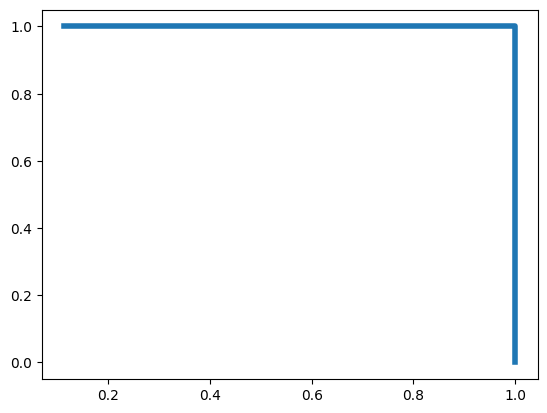

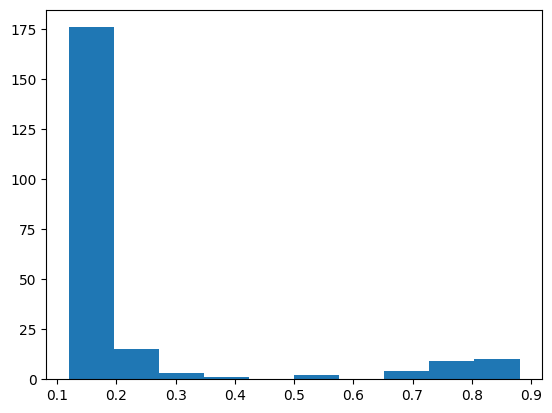

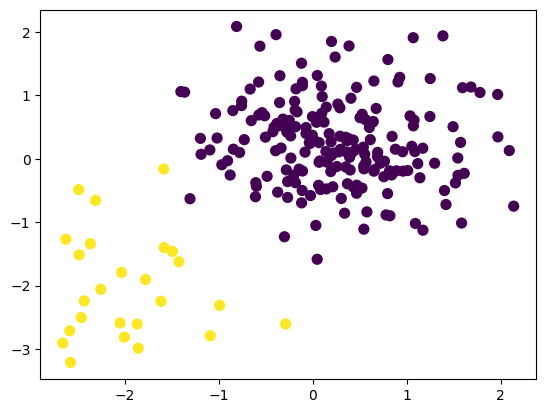

In [34]:
# imbalance calssificaiton
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier

r_forrest = EasyEnsembleClassifier()
r_forrest.fit(train_x, train_y)
pred = r_forrest.predict(test_x)
pred_prop = r_forrest.predict_proba(test_x)[:, 1]
# pred_prop.shape
percision, recall, thresholds = precision_recall_curve(test_y, pred_prop)
print('AUC' + str(auc(recall, percision)))
plt.plot(percision, recall, lw=4)
print(classification_report(test_y, pred))

plt.figure()
plt.hist(pred_prop)
plt.figure()
plt.scatter(test_x[:, 0], test_x[:, 1], s=50, c=pred)

In [33]:
# SVM
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm = SVC(C=1, class_weight='balanced').fit(train_x, train_y)
pred = svm.predict(test_x)
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       195
         1.0       1.00      1.00      1.00        25

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220



In [ ]:
# XGBOOST
import xgboost as xgb

classifer = xgb.XGBClassifier(scale_pos_weight = sum(train_y == 0) / sum(train_y == 1), n_estimators=100, max_depth=5, learning_rate=0.1)
classifer.fit(train_x, train_y)
pred = classifer.predict(test_x)
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       199
         1.0       1.00      1.00      1.00        21

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220



In [35]:
## Deep Learning Methods FC, AE, LSTM, GNN(Randome Walk)

class my_fc(nn.Module):
  def __init__(self, in_features, n_hidden):
    super(my_fc, self).__init__()

    self.n_hid = n_hidden
    self.fc = nn.Linear(in_features=in_features, out_features=n_hidden)
    self.fc1 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
    self.fc2 = nn.Linear(in_features=n_hidden, out_features=1)
    self.sig = nn.Sigmoid()
    self.relu = nn.ReLU()
    self.drp = nn.Dropout(0.2)

  def forward(self, x):
    x = self.relu(self.fc(x))
    x = self.relu(self.fc1(x))
    x = self.drp(x)
    x = self.fc2(x)
    return x



class my_ae(nn.Module):
  def __init__(self, in_features, n_hidden):
    super(my_ae, self).__init__()

    self.n_hid = n_hidden
    self.encoder = nn.Sequential(
        nn.Linear(in_features, 5),
        nn.ReLU(),
        nn.Linear(5, 3)
    )
    self.decoder = nn.Sequential(
    nn.Linear(3, 5),
    nn.ReLU(),
    nn.Linear(5, in_features)
    )


  def forward(self, x):
    latent = self.encoder(x)
    return latent, self.decoder(latent)




In [36]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32)


test_dataset = TensorDataset(test_x_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=test_x_tensor.shape[0])

## model
fc_model = my_fc(in_features=train_x_tensor.shape[1] , n_hidden=10)
print(fc_model)
## Params
optimizer = optim.Adam(fc_model.parameters(), lr=1e-3)
weight = torch.tensor((torch.sum(train_y_tensor==1)/train_y_tensor.shape[0], torch.sum(train_y_tensor==0)/train_y_tensor.shape[0]))
criteria = nn.BCEWithLogitsLoss(pos_weight=weight[-1]/weight[0])
n_epoches = 100
print(weight[-1]/weight[0])

my_fc(
  (fc): Linear(in_features=5, out_features=10, bias=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (sig): Sigmoid()
  (relu): ReLU()
  (drp): Dropout(p=0.2, inplace=False)
)
tensor(10.7333)


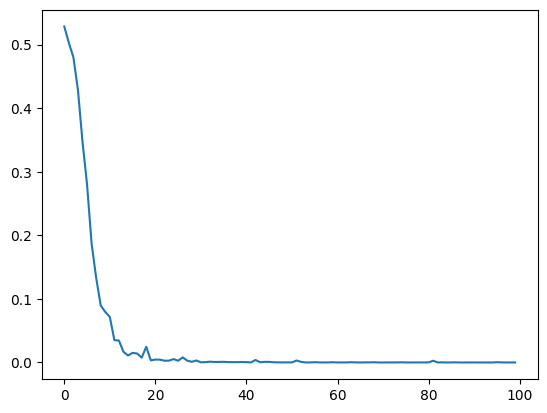

In [37]:
train_loss = []
for i in range(n_epoches):
  for tmp_x, tmp_y in train_loader:
    pred = fc_model(tmp_x)
    optimizer.zero_grad()
    loss = criteria(pred.squeeze(), tmp_y)
    loss.backward()
    optimizer.step()

  train_loss.append(loss.item())

plt.plot(train_loss)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       195
         1.0       1.00      1.00      1.00        25

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220



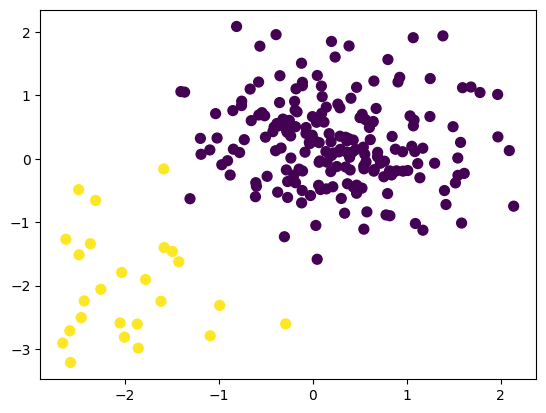

In [38]:
with torch.no_grad():
  fc_model.eval()
  x, y = next(iter(test_loader))
  pred = fc_model(x).squeeze()

pred_binary = pred
pred_binary[pred_binary >= .5] = 1
pred_binary[pred_binary < .5] = 0

print(classification_report(y.detach().numpy(), pred.detach().numpy()))
plt.scatter(x[:, 0], x[:, 1], s=50, c=pred_binary)

my_ae(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
  )
)


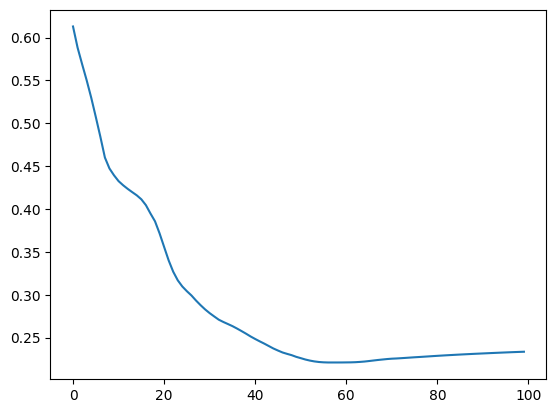

In [39]:
# AE
ae_model = my_ae(in_features=train_x_tensor.shape[1] , n_hidden=10)
optimizer = optim.Adam(ae_model.parameters(), lr=1e-3)
print(ae_model)
criteria = nn.MSELoss()
n_epoches = 100
train_loss = []
ae_model.train()
for i in range(n_epoches):
  for tmp_x, tmp_y in train_loader:
    latent, constructed = ae_model(tmp_x)
    # print(constructed.shape)
    optimizer.zero_grad()
    loss = criteria(constructed, tmp_x)
    loss.backward()
    optimizer.step()

  train_loss.append(loss.item())

plt.plot(train_loss)

(array([ 9.,  8., 14.,  7., 12., 13.,  7., 10.,  7.,  8.,  7., 10., 10.,
         3.,  8.,  7.,  3.,  2.,  3.,  0.,  2.,  3.,  1.,  4.,  8.,  2.,
         3.,  5.,  6.,  2.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,
         1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  1.,  0.,
         0.,  2.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([9.15645331e-04, 1.26722334e-02, 2.44288221e-02, 3.61854099e-02,
        4.79419976e-02, 5.96985854e-02, 7.14551732e-02, 8.32117647e-02,
        9.49683487e-02, 1.06724940e-01, 1.18481524e-01, 1.30238116e-01,
        1.41994700e-01, 1.53751299e-01, 1.65507883e-01, 1.77264467e-01,
        1.89021051e-01, 2.00777650e-01, 2.12534234e-01, 2.24290818e-01,
        2.36047417e-01, 2.47804001e-01, 2.59560585e-01, 2.71317184e-01,
  

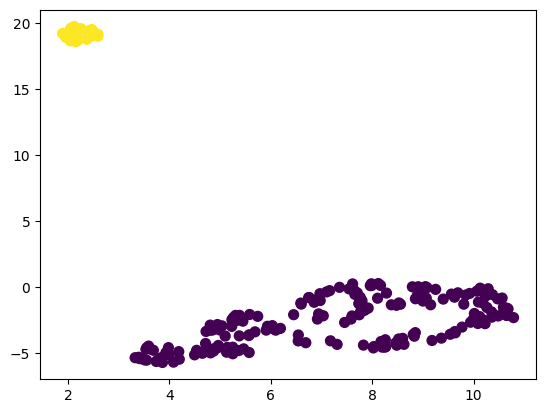

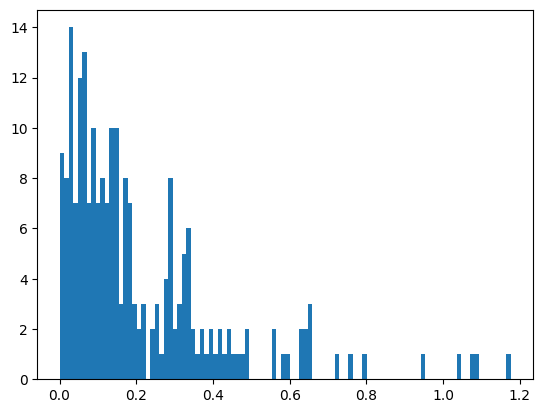

In [40]:
import umap
x, y = next(iter(test_loader))
with torch.no_grad():
  ae_model.eval()
  latent, constrsucted = ae_model(x)
  err = (x - constrsucted) ** 2

umap_model = umap.UMAP(n_components=2)
umap_data = umap_model.fit_transform(latent)
plt.scatter(umap_data[:, 1], umap_data[:, 0], s=50, c=y)
plt.figure()
plt.hist(err.mean(1), 100)
# umap_data
